<a href="https://colab.research.google.com/github/himashi27/Design-and-Analysis-of-Algorithms-Lab-assignment/blob/Capstone-ass/ada_capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

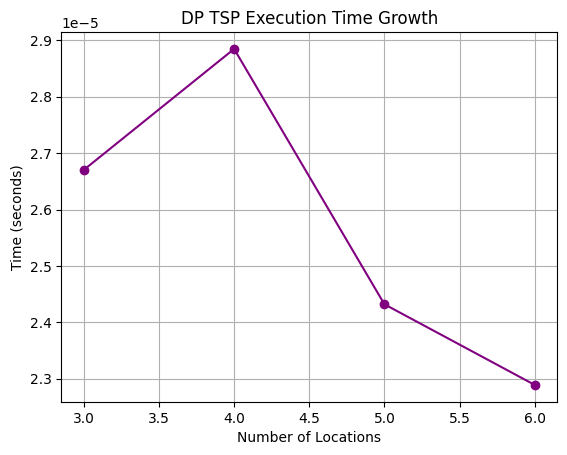

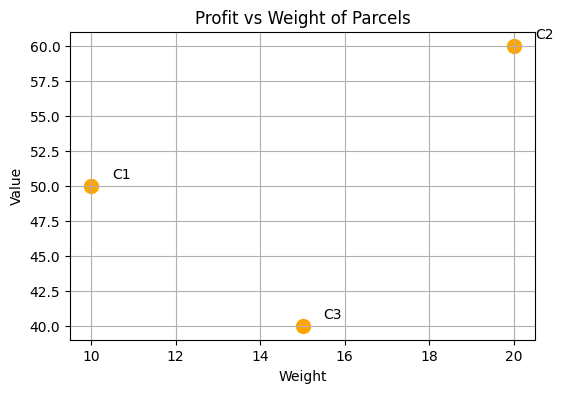

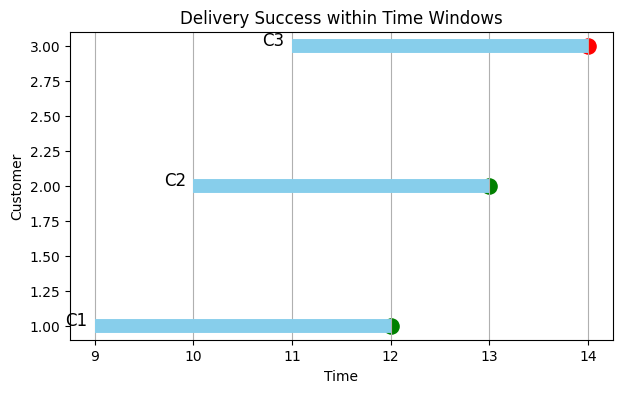

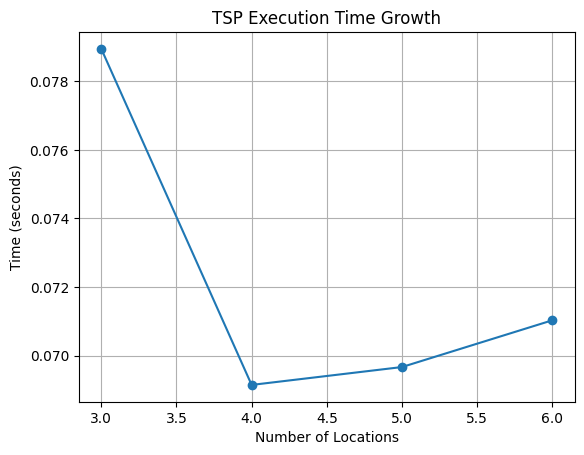

Greedy Selected Parcels: ['C1', 'C2']
Time Window Feasible: True
Shortest Distances from Warehouse: [0, 4, 8, 6]
MST Edges: [('Warehouse', 'C1', 4), ('C1', 'C2', 5), ('C2', 'C3', 3)]
Optimal TSP Route: ['Warehouse', 'C1', 'C2', 'C3', 'Warehouse']
Total Route Cost: 18


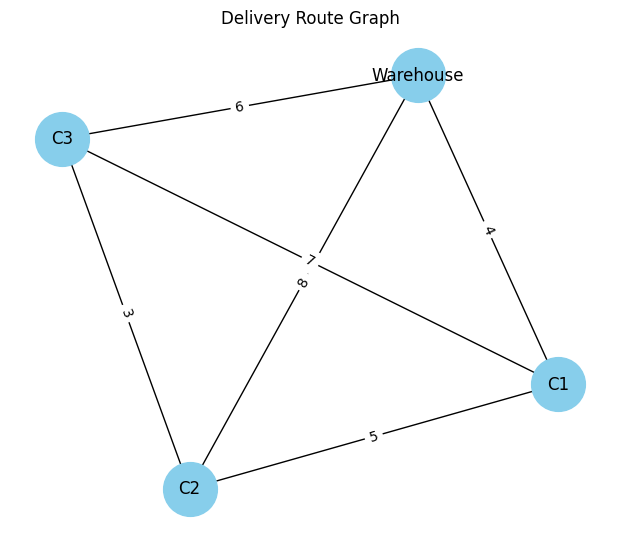


All plots saved in /images folder.


In [2]:
# ============================================================
# DELIVERY ROUTE OPTIMIZATION – FULL COLAB CODE
# For Capstone Assignment (BCA AI&DS – DAA Lab)
# ============================================================

!pip install memory_profiler networkx

import itertools
import time
import random
import matplotlib.pyplot as plt
import networkx as nx
from memory_profiler import memory_usage

import os
os.makedirs("images", exist_ok=True)

# ============================================================
# 1. INPUT MODELING
# ============================================================

locations = ['Warehouse', 'C1', 'C2', 'C3']

distance_matrix = [
    [0, 4, 8, 6],
    [4, 0, 5, 7],
    [8, 5, 0, 3],
    [6, 7, 3, 0]
]

parcels = {
    'C1': {'value': 50, 'time': (9, 12), 'weight': 10},
    'C2': {'value': 60, 'time': (10, 13), 'weight': 20},
    'C3': {'value': 40, 'time': (11, 14), 'weight': 15}
}

vehicle_capacity = 30


# ============================================================
# 2. RECURRENCE FOR COST ESTIMATION (Unit 1)
# ============================================================

def delivery_cost(i, visited):
    """
    Recurrence:
    dp(i, visited) = min over next j of (dist[i][j] + dp(j, visited U j))
    """
    all_visited = (1 << len(locations)) - 1

    if visited == all_visited:
        return distance_matrix[i][0]   # return to warehouse

    best_cost = float("inf")

    for j in range(len(locations)):
        if not (visited & (1 << j)):
            cost = distance_matrix[i][j] + delivery_cost(j, visited | (1 << j))
            best_cost = min(best_cost, cost)

    return best_cost


# ============================================================
# 3. GREEDY SELECTION FOR PARCELS (Unit 2)
# ============================================================

def greedy_parcel_selection(parcels, capacity):
    ratio_list = []
    for c, data in parcels.items():
        v, w = data['value'], data['weight']
        ratio_list.append((v/w, c))

    ratio_list.sort(reverse=True)

    selected = []
    remaining = capacity

    for ratio, c in ratio_list:
        if parcels[c]['weight'] <= remaining:
            selected.append(c)
            remaining -= parcels[c]['weight']

    return selected


# ============================================================
# 4. DP FOR TIME-WINDOW DELIVERY FEASIBILITY (Unit 2)
# ============================================================

def dp_time_window(parcels, selected):
    """
    Checks feasibility using DP based on earliest finish time
    """
    selected_times = [parcels[c]["time"] for c in selected]
    selected_times.sort()  # sort by earliest start

    dp = [True]
    end_time = 8  # start time

    for (start, end) in selected_times:
        if end_time <= end:
            end_time = max(end_time, start) + 1
            dp.append(True)
        else:
            dp.append(False)

    return all(dp)


# ============================================================
# 5. DIJKSTRA SHORTEST PATH (Unit 3)
# ============================================================

def dijkstra(start):
    n = len(locations)
    dist = [float('inf')] * n
    visited = [False] * n
    dist[start] = 0

    for _ in range(n):
        u = min((d, i) for i, d in enumerate(dist) if not visited[i])[1]
        visited[u] = True

        for v in range(n):
            if distance_matrix[u][v] > 0:
                dist[v] = min(dist[v], dist[u] + distance_matrix[u][v])

    return dist


# ============================================================
# 6. PRIM’S MST (Unit 3)
# ============================================================

def prim_mst():
    n = len(locations)
    selected = [False] * n
    selected[0] = True
    edges = []

    for _ in range(n - 1):
        m = float('inf')
        x = 0
        y = 0
        for i in range(n):
            if selected[i]:
                for j in range(n):
                    if (not selected[j]) and distance_matrix[i][j] < m:
                        m = distance_matrix[i][j]
                        x = i
                        y = j
        edges.append((locations[x], locations[y], m))
        selected[y] = True

    return edges


# ============================================================
# 7. TSP (BRUTE-FORCE) – Unit 4
# ============================================================

def tsp_bruteforce(locations, distance_matrix):
    n = len(locations)
    indices = list(range(1, n))
    min_cost = float('inf')
    best_route = None

    for perm in itertools.permutations(indices):
        cost = distance_matrix[0][perm[0]]
        for i in range(len(perm)-1):
            cost += distance_matrix[perm[i]][perm[i+1]]
        cost += distance_matrix[perm[-1]][0]

        if cost < min_cost:
            min_cost = cost
            best_route = perm

    return [locations[0]] + [locations[i] for i in best_route] + [locations[0]], min_cost

# ============================================================
# HELD-KARP DYNAMIC PROGRAMMING TSP
# ============================================================

def tsp_dp(locations, dist):
    n = len(locations)
    ALL = 1 << n

    dp = [[float('inf')] * n for _ in range(ALL)]
    dp[1][0] = 0  # start at Warehouse

    # DP over subsets
    for mask in range(ALL):
        for i in range(n):
            if mask & (1 << i):
                prev = dp[mask][i]
                if prev < float('inf'):
                    for j in range(n):
                        if not (mask & (1 << j)):
                            new_mask = mask | (1 << j)
                            dp[new_mask][j] = min(dp[new_mask][j], prev + dist[i][j])

    # return to warehouse
    best = float('inf')
    for i in range(1, n):
        best = min(best, dp[ALL - 1][i] + dist[i][0])

    return best
# ============================================================
# DP TIME COMPLEXITY PROFILING
# ============================================================

sizes = [3, 4, 5, 6]
dp_times = []

for s in sizes:
    sub_locs = locations[:s]
    sub_mat = [row[:s] for row in distance_matrix[:s]]

    start = time.time()
    tsp_dp(sub_locs, sub_mat)
    end = time.time()

    dp_times.append(end - start)

# Plot for DP TSP
plt.plot(sizes, dp_times, marker='o', color='purple')
plt.title("DP TSP Execution Time Growth")
plt.xlabel("Number of Locations")
plt.ylabel("Time (seconds)")
plt.grid(True)
plt.savefig("images/tsp_dp_time.png", dpi=300)
plt.show()

# ============================================================
# PROFIT VS WEIGHT PLOT
# ============================================================

weights = [parcels[c]['weight'] for c in parcels]
values = [parcels[c]['value'] for c in parcels]
labels = list(parcels.keys())

plt.figure(figsize=(6,4))
plt.scatter(weights, values, s=100, c='orange')

for i, txt in enumerate(labels):
    plt.text(weights[i] + 0.5, values[i] + 0.5, txt)

plt.title("Profit vs Weight of Parcels")
plt.xlabel("Weight")
plt.ylabel("Value")
plt.grid(True)
plt.savefig("images/profit_vs_weight.png", dpi=300)
plt.show()

# ============================================================
# DELIVERY TIME-WINDOW VISUALIZATION
# ============================================================

plt.figure(figsize=(7,4))

y = 1
for c in parcels:
    start, end = parcels[c]['time']

    # Draw time window
    plt.hlines(y, start, end, colors='skyblue', linewidth=10)

    # If selected and feasible, mark green; else mark red
    if c in greedy_selected and dp_time_window(parcels, greedy_selected):
        plt.scatter(end, y, color='green', s=120)  # delivery point
    else:
        plt.scatter(end, y, color='red', s=120)

    plt.text(start - 0.3, y, c, fontsize=12)
    y += 1

plt.title("Delivery Success within Time Windows")
plt.xlabel("Time")
plt.ylabel("Customer")
plt.grid(True, axis='x')
plt.savefig("images/time_window_plot.png", dpi=300)
plt.show()


# ============================================================
# 8. VISUALIZE NETWORK ROUTE (Unit 3)
# ============================================================

def plot_route_graph(locations, matrix):
    G = nx.Graph()
    for i in range(len(locations)):
        for j in range(i+1, len(locations)):
            G.add_edge(locations[i], locations[j], weight=matrix[i][j])

    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(6,5))
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=1500)
    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

    plt.title("Delivery Route Graph")
    plt.savefig("images/route_graph.png", dpi=300)
    plt.show()


# ============================================================
# 9. PROFILING – TSP Scaling
# ============================================================

sizes = [3, 4, 5, 6]
exec_times = []
memory_usage_list = []

for s in sizes:
    sub_locs = locations[:s]
    sub_mat = [row[:s] for row in distance_matrix[:s]]

    start = time.time()
    mem = memory_usage((tsp_bruteforce, (sub_locs, sub_mat)))
    route, cost = tsp_bruteforce(sub_locs, sub_mat)
    end = time.time()

    exec_times.append(end - start)
    memory_usage_list.append(max(mem))

# Plot time complexity
plt.plot(sizes, exec_times, marker='o')
plt.title("TSP Execution Time Growth")
plt.xlabel("Number of Locations")
plt.ylabel("Time (seconds)")
plt.grid(True)
plt.savefig("images/tsp_time.png", dpi=300)
plt.show()


# ============================================================
# 10. FINAL EXECUTION
# ============================================================

greedy_selected = greedy_parcel_selection(parcels, vehicle_capacity)
feasible = dp_time_window(parcels, greedy_selected)
shortest_paths = dijkstra(0)
mst_edges = prim_mst()
final_route, final_cost = tsp_bruteforce(locations, distance_matrix)

print("Greedy Selected Parcels:", greedy_selected)
print("Time Window Feasible:", feasible)
print("Shortest Distances from Warehouse:", shortest_paths)
print("MST Edges:", mst_edges)
print("Optimal TSP Route:", final_route)
print("Total Route Cost:", final_cost)

plot_route_graph(locations, distance_matrix)

print("\nAll plots saved in /images folder.")
